## Supplementary Materials: Prior selection & prior predictive check

**this is supplementary for ten simple step, maybe we will continue in the future.**

Here, we will check the priors implemented in HDDM. The question we address in this step is: if we randomly draw values of parameters from their priors and use these parameter values to generate reaction times and responses, will the reaction times and responses make sense? This will help us to understand whether the prior make sense, even without looking at the data.

To answer the question, we checked two possible priors: noninformative as implemented in HDDM and the weakly informative prior implemented in HDDM. 

For all these three prior, we used the following three step to check:
* First, randomly draw each parameter's values from its prior distribution; 
* Second, we will use these values of parameters as the input of  `gen_rand_data` and generate data of one participants (of course, we can also generate data with the same structure of our real data; 
* Third, calculate the mean reaction time and the accuracy of the simulated the data. 

We iterate these three steps for 10000 times and plot the mean RT and accuracy data.

This step is for illustrative purpose, because it is not easy to change prior in HDDM, and it is not recommended for new users.

### Priors 

The script to define the non-informative prior and weakly informative prior is at `./hddm/models/hddm_info.py`, line 142 - line 159 and line 121 - line 140. These code relies on other functions to create corresponding distribution family in `hddm/models/base.py`, such as `_create_family_gamma_gamma_hnormal`, these function further depends on `pymc/distribution.py`, in which the class name were re-capitalized ('half_normal' -> 'HalfNormal').


For simiplicity, we only check the four main parameters for simplified DDM, instead of full DDM with seven parameters. We will use the default setting in `generate_rts` in HDDM, i.e., $sv=0, st=0, sz=0$.

Steps for prior check

Step 1: random sample 4 parameter from the prior;

Step 2: generate data using these 4 parameters

Step 3: calculate the mean of RT from the generated data

We present the simulation first. We also ploted the distribution of parameter values draw from the prior at the end of the notebook.

#### Non-informative priors

This prior had been mentioned in Wiecki et al (2013) and was implemented in HDDM. This is the prior distribution used when you set the argument 'is_informative' as False (the default is set as True). This prior a diffused prior, with a very large SD for each parameter.

$a_{j} \sim \mathcal{truncN}(\mu_{a}, \sigma_{a}^2, 1e-3, 1e3)$, $ \mu_{a} \sim \mathcal{U}(1e-3, 1e3)$, $\sigma_{a} \sim \mathcal{U}(1e-3, 1e3)$;

$v_{j} \sim \mathcal{N}(\mu_{v}, \sigma_{v}^2)$, $ \mu_{v} \sim \mathcal{N}(0.00, 50.00)$, $\sigma_{v} \sim \mathcal{HN}(10.0)$; 

$z_{j} \sim invlogit(\mathcal{N}(\mu_{z}, \sigma_{z}^2))$, $ \mu_{z} \sim \mathcal{N}(0.50, 10.)$; $\sigma_{z} \sim \mathcal{HN}(0.5)$; 

$a_{j} \sim \mathcal{truncN}(\mu_{a}, \sigma_{a}^2, 1e-3, 1e3)$, $ \mu_{a} \sim \mathcal{U}(1e-3, 1e3)$, $\sigma_{a} \sim \mathcal{U}(1e-3, 1e3)$;

$ \mathcal{sv} \sim \mathcal{U}(1e-6, 1e3)$; 

$ \mathcal{st} \sim \mathcal{U}(1e-6, 1e3)$; 

$\mathcal{sz} \sim \mathcal{B}(1, 1)$, 

in which the $\mathcal{truncN}$ means truncated normal distribution, $\mathcal{U}$ means uniformed distribution.

#### Weakly informative priors

This default prior in HDDM, weakly informative prior, was based on Matzke & Wagenmakes (2009, Appendix A, and supplementary). Note, Matzke and Wagenmakes (2009) summaried 23 papers and provided the frequencies of **9** parameters, but Wiekie et al (2013) defined **11** group-level parameters and **4** individual-level parameters.

$a_{j} \sim \mathcal{G}(\mu_{a}, \sigma_{a}^2)$, $ \mu_{a} \sim \mathcal{G}(1.50, 0.75)$, $\sigma_{a} \sim \mathcal{HN}(0.1)$; 

$v_{j} \sim \mathcal{N}(\mu_{v}, \sigma_{v}^2)$, $ \mu_{v} \sim \mathcal{N}(2.00, 3.00)$, $\sigma_{v} \sim \mathcal{HN}(2.0)$; 

$z_{j} \sim invlogit(\mathcal{N}(\mu_{z}, \sigma_{z}^2))$, $ \mu_{z} \sim \mathcal{N}(0.50, 0.50)$; $\sigma_{z} \sim \mathcal{HN}(0.05)$; 

$t_{j} \sim \mathcal{N}(\mu_{t}, \sigma_{t}^2)$, $ \mu_{t} \sim \mathcal{G}(0.40, 0.20)$, $\sigma_{t} \sim \mathcal{HN}(1)$; 

$ \mathcal{sv} \sim \mathcal{HN}(2)$; 

$ \mathcal{st} \sim \mathcal{HN}(0.3)$; 

$\mathcal{sz} \sim \mathcal{B}(1, 3)$ 

Note, in the `hddm/models/hddm_info.py L 124`, the `std_std =2 ` means that the simga of a is `2` instead of `0.1` as stated in the paper.

In [1]:
import statistics
import numpy as np
from scipy import stats

import hddm
import pymc as pm

import matplotlib.pyplot as plt
import seaborn as sns

/opt/conda/lib/python3.7/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


In [2]:
import sys
def invlogit(ltheta, eps=sys.float_info.epsilon):
    """The inverse of the logit function, 1 / (1 + exp(-x))."""
    ltheta = np.array(ltheta, dtype=np.float128)
    return (1.0 - 2.0 * eps) / (1.0 + np.exp(-ltheta)) + eps

def draw_a_prior(g_mean=1.5, g_std=0.75, std_std=0.1, std_value=2, size = 1):
    '''
    draw parameter a from its prior
    refer: hddm/models/base.py#L639
    return three parameters: group level mean, std, subject level data
    '''
    g_shape = (g_mean**2) / (g_std**2)
    g_rate = g_mean / (g_std**2)
    g_beta=g_rate

    g_mu_a = np.random.gamma(shape=g_shape, scale = 1./ g_beta, size = size)

    tau=std_std**-2 # why using std_std instead of std_value?
    g_std_a = abs(np.random.normal(0, np.sqrt(1 / tau), size=size))

    shape = (g_mu_a**2)/(g_std_a**2)

    rate = g_mu_a/(g_std_a**2)
    beta = rate

    subj_a = np.random.gamma(shape=shape, scale = 1./ beta, size=size)

    return subj_a, g_mu_a, g_std_a

def draw_t_prior(g_mean=.4, g_std=0.2, value=0.001, std_std=1, std_value=0.2, size=1):
    '''
    draw parameter t from its prior
    '''
    g_shape = (g_mean**2) / (g_std**2)
    g_rate = g_mean / (g_std**2)
    g_beta=g_rate

    g_mu_t = np.random.gamma(shape=g_shape, scale = 1./ g_beta, size = size)

    tau_g =std_std**-2
    g_std_t = abs(np.random.normal(0, np.sqrt(1 / tau_g), size=size))

    #tau = std ** -2
    shape = (g_mu_t**2)/(g_std_t**2)

    rate = g_mu_t/(g_std_t**2)

    beta = rate

    #subj_t = np.random.normal(g, 1. / np.sqrt(tau), size)
    subj_t = np.random.gamma(shape=shape, scale = 1./ beta, size=size)

    return subj_t, g_mu_t, g_std_t

def draw_v_prior(value=2, g_mu=2,g_tau=3**-2, std_std=2, size=1):
    '''
    draw parameter v from its prior
    '''
    if g_mu is None:
        g_mu = value

    g_mu_v = np.random.normal(g_mu, 1. / np.sqrt(g_tau), size=size)
    tau_g=std_std**-2

    g_std_v = abs(np.random.normal(0, 1./ np.sqrt(tau_g), size=size)) # half-normal distribution

    tau = g_std_v ** -2
    #print('tau', tau)
    subj_v = np.random.normal(g_mu_v, 1./ np.sqrt(tau), size=size)

    return subj_v, g_mu_v, g_std_v

def draw_z_prior(value=.5, g_mu = None, g_tau=0.5**-2, std_std=0.05, size=1):
    '''
    draw parameter z from its prior
    '''
    if g_mu is None:
        g_mu = value
    g_mu_trans = g_mu

    g_mu_z = np.random.normal(g_mu_trans, 1. / np.sqrt(g_tau), size)

    g = invlogit(ltheta=g_mu_z)

    g_tau = std_std**-2

    g_std_z = abs(np.random.normal(0, np.sqrt(1. / g_tau), size=size)) # half normal

    tau = g_std_z ** -2
    subj_trans = np.random.normal(g_mu_z, np.sqrt(1./tau), size=size)

    subj_z = invlogit(ltheta=subj_trans)

    return subj_z, g_mu_z, g_std_z

#### Check the non-informative prior

In [3]:
def rtruncated_normal(mu, tau, a=-np.inf, b=np.inf, size=1):
    from scipy.stats import norm
    sigma = 1. / np.sqrt(tau)
    #na = utils.normcdf((a - mu) / sigma)  # here ther utils.normcdf also used flib
    #nb = utils.normcdf((b - mu) / sigma)
    na = norm.cdf((a - mu) / sigma)
    nb = norm.cdf((b - mu) / sigma)

    # Use the inverse CDF generation method.
    U = np.random.mtrand.uniform(size=size)
    q = U * nb + (1 - U) * na
    
    from scipy.special import ndtri # invcdf mentioned in solution (3) above
    # R = utils.invcdf(q)
    R = ndtri(q)

    # Unnormalize
    return R * sigma + mu

def draw_a_noninfo(lower=1e-3, upper=1e3, size=1):
    g_mu_a = np.random.uniform(low=lower, high=upper, size=size)
    g_std_a = np.random.uniform(low=1e-10, high=100, size=size)
    tau = g_std_a**-2
    #sigma = 1. / np.sqrt(tau)
    
    subj_a = rtruncated_normal(mu=g_mu_a, tau=tau, a=lower, b=upper, size=size)
    
    return subj_a, g_mu_a, g_std_a

def draw_t_noninfo(lower=1e-3, upper=1e3, size=1):
    g_mu_t = np.random.uniform(low=lower, high=upper, size=size)
    g_std_t = np.random.uniform(low=1e-10, high=100, size=size)
    tau = g_std_t**-2
    #sigma = 1. / np.sqrt(tau)
    
    subj_t = rtruncated_normal(mu=g_mu_t, tau=tau, a=lower, b=upper, size=size)
    
    return subj_t, g_mu_t, g_std_t

def draw_v_noninfo(value=0, g_mu = None, g_tau=50**-2, std_std=10, size=1):
    if g_mu is None:
        g_mu = value
    
    g = np.random.normal(g_mu, 1. / np.sqrt(g_tau), size=size)
    tau_g=std_std**-2
    
    std_g = abs(np.random.normal(0, 1./ np.sqrt(tau_g), size=size)) # half-normal distribution
    
    tau = std_g ** -2
    #print('tau', tau)
    subj_v = np.random.normal(g, 1./ np.sqrt(tau), size=size)
    
    return subj_v, g, std_g

def draw_z_noninfo(value=.5, g_mu = None, g_tau=10**-2, std_std=0.5, size=1):
    
    if g_mu is None:
        g_mu = value
    g_mu_trans = g_mu
    
    # g_mu_trans = np.log(g_mu) - np.log(1-g_mu) #### this deviate from prior!!
    g_trans = np.random.normal(g_mu_trans, 1. / np.sqrt(g_tau), size)
    #print('g_trans is: ', g_trans)
    g = invlogit(ltheta=g_trans)
    
    #print('g is: ', g)
    
    g_tau = std_std**-2
    #print('g_tau is: ', g_tau)
    
    g_std = abs(np.random.normal(0, np.sqrt(1. / g_tau), size=size)) # half normal
    #print('g_std is: ', g_std)
    
    tau = g_std ** -2
    subj_trans = np.random.normal(g_trans, np.sqrt(1./tau), size=size)
   
    subj_z = invlogit(ltheta=subj_trans)
    
    return subj_z, g, g_std

In [4]:
def gen_data_from_prior(n = 1, type = None):
    '''
    Define a function to simulate the RT and response using params draw from prior
    '''
    import pandas as pd

    cols = ['prior_a', 'prior_v', 'prior_t', 'prior_z',
            'mean_rt', 'acc']
    df = pd.DataFrame(columns=cols)

    for ii in range(n):
        
        # if use wiecki_2013's prior
        if type == 'wiecki_2013':
            
            a = draw_a_prior(size=1)[0][0]
            v = draw_v_prior(size=1)[0][0]
            t = draw_t_prior(size=1)[0][0]
            z = draw_z_prior(size=1)[0][0]
        
        # if use noninformative prior
        elif type == 'noninfo':
            a = draw_a_noninfo(size=1)[0][0]
            v = draw_v_noninfo(size=1)[0][0]
            t = draw_t_noninfo(size=1)[0][0]
            z = draw_z_noninfo(size=1)[0][0]
        else:
            print('Please choose the prior type')
            break

        params = {'a': a,
                  'v': v,
                  't': t,
                  'z': z}

        data, params = hddm.generate.gen_rand_data(params, size=120, subjs=1)
        # Note: not be able to use method = 'drift' of the gen_rt function

        df = df.append({'prior_a': a, 
                        'prior_v': v, 
                        'prior_t': t, 
                        'prior_z': z,
                        'mean_rt': statistics.mean(data['rt']), 
                        'acc': statistics.mean(data['response'])}, 
                       ignore_index=True)

    return df

In [5]:
df_inf = gen_data_from_prior(n = 10000, type = 'wiecki_2013')

/opt/conda/lib/python3.7/site-packages/hddm/generate.py:194: RuntimeWarning: invalid value encountered in true_divide
  size, range_[0], range_[1], dt)


In [6]:
df_noninf = gen_data_from_prior(n = 10000, type = 'noninfo')

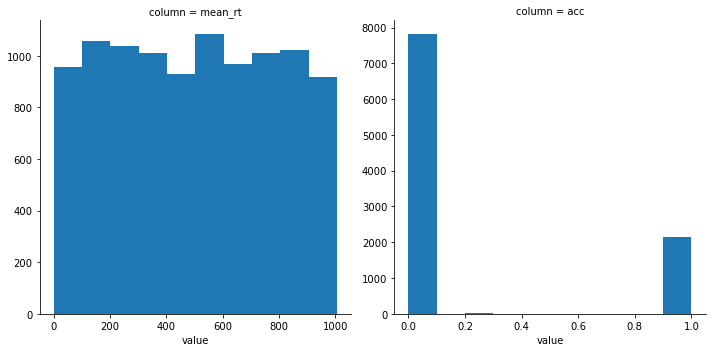

In [7]:
df_noninf_s = df_noninf[['mean_rt', 'acc']].copy()     # select mean RT and accuracy
df_noninf_melted = df_noninf_s.melt(var_name='column') # to long format

# plot the long format data
g = sns.FacetGrid(df_noninf_melted, col='column', sharex=False, sharey=False, height=5)
g.map(plt.hist, 'value')

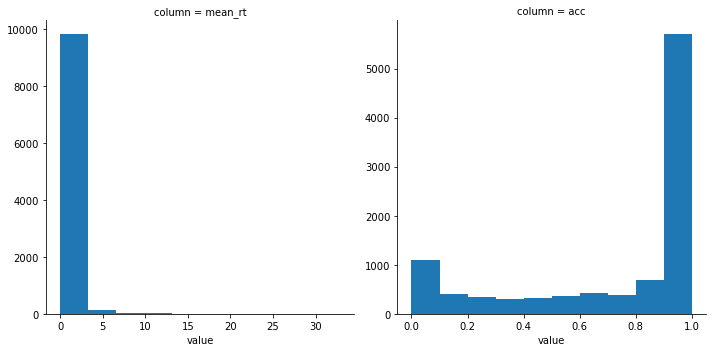

In [8]:
df_inf_s = df_inf[['mean_rt', 'acc']].copy()     # select mean RT and accuracy
df_inf_melted = df_inf_s.melt(var_name='column') # to long format

# plot the long format data
g = sns.FacetGrid(df_inf_melted, col='column', sharex=False, sharey=False, height=5)
g.map(plt.hist, 'value')

### Details of the informative prioirs
##### Draw a random value from prior distribution of $a$

$$ a_{j} \sim \mathcal{G}(\mu_{a}, \sigma_{a}^2) $$, $$ \mu_{a} \sim \mathcal{G}(1.50, 0.75)$$, $$\sigma_{a} \sim \mathcal{HN}(0.1)$$ 

*I doubt here the `std_std` (hddm/models/hddm_info.py#L124) should be 0.1 instead of 2*

mean of a:  1.4358272207204958
mean of mu_a:  1.4808159926047604
std of mu_a:  0.7371396403913155
fit of std_a, location and scale:  (0.0020991555799809744, 1.978383706365044)


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

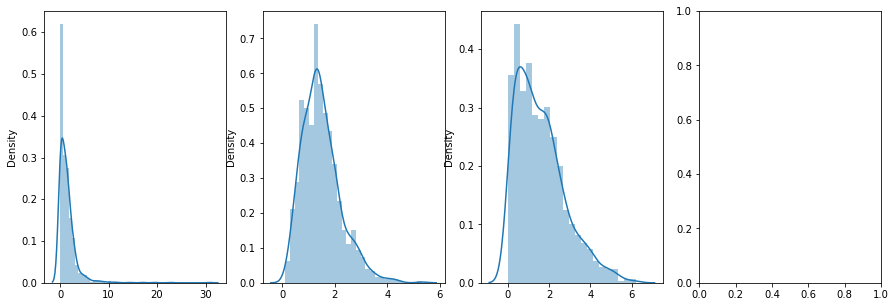

In [9]:
# in /hddm/models/hddm_info.py#L124 `_create_stochastic_knodes_info`
# knodes.update(self._create_family_gamma_gamma_hnormal('a', g_mean=1.5, g_std=0.75, 
#                                                            std_std=2, std_value=0.1, value=1))

# def _create_family_gamma_gamma_hnormal(self, name, value=1, g_mean=1, g_std=1, std_std=2, std_value=.1):
#        knodes = OrderedDict()
#        g_shape = (g_mean**2) / (g_std**2)
#        g_rate = g_mean / (g_std**2)
#        if self.is_group_model and name not in self.group_only_nodes:
#            g = Knode(pm.Gamma, name, alpha=g_shape, beta=g_rate,
#                            value=g_mean, depends=self.depends[name])
#            depends_std = self.depends[name] if self.std_depends else ()
#            std = Knode(pm.HalfNormal, '%s_std' % name, tau=std_std**-2,
#                        value=std_value, depends=depends_std)#
#
#            shape = Knode(pm.Deterministic, '%s_shape' % name, eval=lambda x,y: (x**2)/(y**2),
#                        x=g, y=std, plot=False, trace=False, hidden=True)
#
#            rate = Knode(pm.Deterministic, '%s_rate' % name, eval=lambda x,y: x/(y**2),
#                        x=g, y=std, plot=False, trace=False, hidden=True)
#
#            subj = Knode(pm.Gamma, '%s_subj'%name, alpha=shape, beta=rate,
#                         value=value, depends=('subj_idx',),
#                         subj=True, plot=False)
#
#            knodes['%s'%name]            = g
#            knodes['%s_std'%name]        = std
#            knodes['%s_rate'%name]       = rate
#            knodes['%s_shape'%name]      = shape
#            knodes['%s_bottom'%name]     = subj
#
#        else:
#            g = Knode(pm.Gamma, name, alpha=g_shape, beta=g_rate, value=value,
#                            depends=self.depends[name])
#
#            knodes['%s_bottom'%name] = g
#
#        return knodes

# in `pymc/distribution.py`
# the gamma distribution
# def rgamma(alpha, beta, size=None):
#     """
#     Random gamma variates.
#     """
#
#     return np.random.gamma(shape=alpha, scale=1. / beta, size=size)

# the half_normal ditribution
# def rhalf_normal(tau, size=None):
#     """
#     Random half-normal variates.
#     """
#
#     return abs(np.random.normal(0, np.sqrt(1 / tau), size))

#### std_std=0.1
def draw_a_prior(g_mean=1.5, g_std=0.75, std_std=0.1, std_value=2, size = 1):
    g_shape = (g_mean**2) / (g_std**2)
    g_rate = g_mean / (g_std**2)
    g_beta=g_rate
    
    g = np.random.gamma(shape=g_shape, scale = 1./ g_beta, size = size)
    
    tau=std_std**-2 # why using std_std instead of std_value?
    std = abs(np.random.normal(0, np.sqrt(1 / tau), size=size))
    
    shape = (g**2)/(std**2)
    
    rate = g/(std**2)
    beta = rate
    
    subj_a = np.random.gamma(shape=shape, scale = 1./ beta, size=size)
    
    return subj_a, g, std

subj_a, g, std = draw_a_prior(size = 1000, std_std=2)
# print(subj_a)
print('mean of a: ', statistics.mean(subj_a))
print('mean of mu_a: ', statistics.mean(g))
print('std of mu_a: ', statistics.stdev(g))
print('fit of std_a, location and scale: ', stats.halfnorm.fit(std))

f, axes = plt.subplots(1, 4, figsize=(15,5))
sns.distplot(subj_a, ax = axes[0])
sns.distplot(g, ax = axes[1])
sns.distplot(std, ax = axes[2])

##### Draw a value from prior of $t$. 

$$t_{j} \sim \mathcal{N}(\mu_{t}, \sigma_{t}^2)$$ $$ \mu_{t} \sim \mathcal{G}(0.40, 0.20)$$ $$\sigma_{t} \sim \mathcal{HN}(1)$$


mean of mu_t:  0.4016137140285445
std of mu_t:  0.19955926760151058
std of std_t:  (0.00010083492244143428, 0.9973310887441442)


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

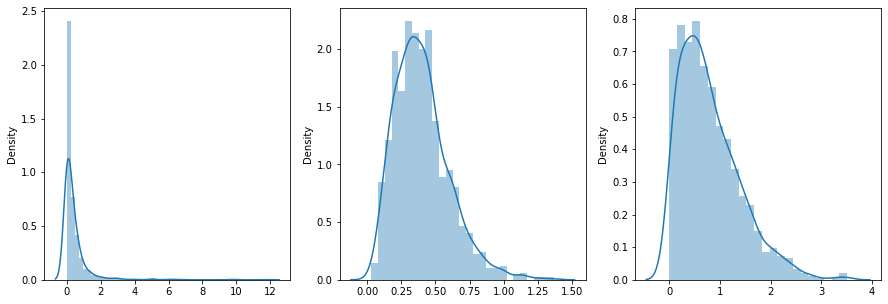

In [10]:
# draw a random t from the prior

# in hddminfo.py `_create_stochastic_knodes_info`
# knodes.update(self._create_family_gamma_gamma_hnormal('t', g_mean=.4, g_std=0.2,  
#                                                       std_std=1, std_value=0.2, value=0.001))

# in hddm/models/base.py
# def _create_family_gamma_gamma_hnormal(self, name, value=1, g_mean=1, g_std=1, std_std=2, std_value=.1):
#
#        knodes = OrderedDict()
#        g_shape = (g_mean**2) / (g_std**2)
#        g_rate = g_mean / (g_std**2)
#        if self.is_group_model and name not in self.group_only_nodes:
#            g = Knode(pm.Gamma, name, alpha=g_shape, beta=g_rate,
#                            value=g_mean, depends=self.depends[name])
#            depends_std = self.depends[name] if self.std_depends else ()
#            std = Knode(pm.HalfNormal, '%s_std' % name, tau=std_std**-2,
#                        value=std_value, depends=depends_std)#
#
#            shape = Knode(pm.Deterministic, '%s_shape' % name, eval=lambda x,y: (x**2)/(y**2),
#                        x=g, y=std, plot=False, trace=False, hidden=True)
#
#            rate = Knode(pm.Deterministic, '%s_rate' % name, eval=lambda x,y: x/(y**2),
#                        x=g, y=std, plot=False, trace=False, hidden=True)
#
#
#            subj = Knode(pm.Gamma, '%s_subj'%name, alpha=shape, beta=rate,
#                         value=value, depends=('subj_idx',),
#                         subj=True, plot=False)
#
#            knodes['%s'%name]            = g
#            knodes['%s_std'%name]        = std
#            knodes['%s_rate'%name]       = rate
#            knodes['%s_shape'%name]      = shape
#            knodes['%s_bottom'%name]     = subj
#
#        else:
#            g = Knode(pm.Gamma, name, alpha=g_shape, beta=g_rate, value=value,
#                            depends=self.depends[name])
#
#            knodes['%s_bottom'%name] = g
#
#        return knodes

# in `pymc/distribution.py`
# the gamma distribution
# def rgamma(alpha, beta, size=None):
#     """
#     Random gamma variates.
#     """
#
#     return np.random.gamma(shape=alpha, scale=1. / beta, size=size)


# the half_normal ditribution
# def rhalf_normal(tau, size=None):
#     """
#     Random half-normal variates.
#     """
#     return abs(np.random.normal(0, np.sqrt(1 / tau), size))

# in `pymc/distribution.py`
# def rnormal(mu, tau, size=None):
#     """
#     Random normal variates.
#     """
#     return np.random.normal(mu, 1. / np.sqrt(tau), size)

def draw_t_prior(g_mean=.4, g_std=0.2, value=0.001, std_std=1, std_value=0.2, size=1):
    g_shape = (g_mean**2) / (g_std**2)
    g_rate = g_mean / (g_std**2)
    g_beta=g_rate
    
    g = np.random.gamma(shape=g_shape, scale = 1./ g_beta, size = size)
    
    tau_g =std_std**-2
    std = abs(np.random.normal(0, np.sqrt(1 / tau_g), size=size))
    
    #tau = std ** -2
    shape = (g**2)/(std**2)
    
    rate = g/(std**2)
    
    beta = rate
    
    #subj_t = np.random.normal(g, 1. / np.sqrt(tau), size)
    subj_t = np.random.gamma(shape=shape, scale = 1./ beta, size=size)
    
    return subj_t, g, std

subj_t, g, std = draw_t_prior(size = 1000, std_std=1)
# list = [subj_t, g, std]
# param_t = pd.DataFrame(data = list, columns= ["subj_t", "g", "std"])

#print(subj_t)

print('mean of mu_t: ', statistics.mean(g))
print('std of mu_t: ', statistics.stdev(g))
print('std of std_t: ', stats.halfnorm.fit(std))

f, axes = plt.subplots(1, 3, figsize=(15,5))
sns.distplot(subj_t, ax = axes[0])
sns.distplot(g, ax = axes[1])
sns.distplot(std, ax = axes[2])

##### Draw a random value from prior distribution of $v$

$v_{j} \sim \mathcal{N}(\mu_{v}, \sigma_{v}^2)$, $ \mu_{v} \sim \mathcal{N}(2.00, 3.00)$, $\sigma_{v} \sim \mathcal{HN}(2.0)$; 

mean of mu_v:  2.0306811329424748
std of mu_v:  3.0024906353730008
std of std_v:  (0.002629472547825043, 1.9108234100730126)


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

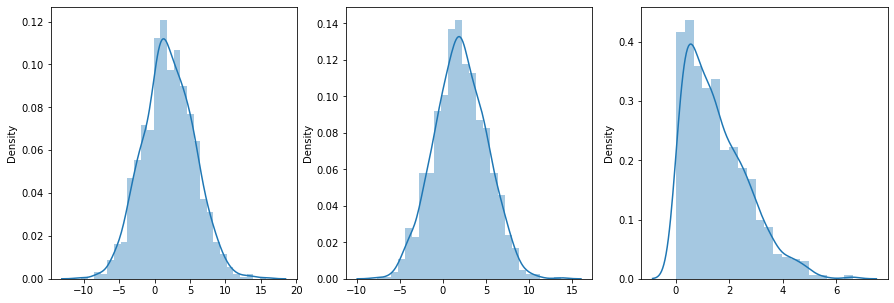

In [11]:
# in hddminfo.py `_create_stochastic_knodes_info`
# knodes.update(self._create_family_normal_normal_hnormal('v', value=2, g_mu=2, g_tau=3**-2, std_std=2))

# in hddm/models/base.py
# def _create_family_normal_normal_hnormal(self, name, value=0, g_mu=None,
#                              g_tau=15**-2, std_std=2,
#                              std_value=.1):
#         """Create a family of knodes. A family is a group of knodes
#         that belong together.
#         For example, a family could consist of the following distributions:
#         * group mean g_mean (Normal(g_mu, g_tau))
#         * group standard deviation g_std (Uniform(std_lower, std_upper))
#         * transform node g_std_trans for g_std (x -> x**-2)
#         * subject (Normal(g_mean, g_std_trans))
#         In fact, if is_group_model is True and the name does not appear in
#         group_only nodes, this is the family that will be created.
#         Otherwise, only a Normal knode will be returned.
#         :Arguments:
#             name : str
#                 Name of the family. Each family member will have this name prefixed.
#         :Optional:
#             value : float
#                 Starting value.
#             g_mu, g_tau, std_lower, std_upper, std_value : float
#                 The hyper parameters for the different family members (see above).
#         :Returns:
#             OrderedDict: member name -> member Knode
#         """
#         if g_mu is None:
#             g_mu = value
# 
#         knodes = OrderedDict()
#
#        if self.is_group_model and name not in self.group_only_nodes:
#            g = Knode(pm.Normal, '%s' % name, mu=g_mu, tau=g_tau,
#                      value=value, depends=self.depends[name])
#            depends_std = self.depends[name] if self.std_depends else ()
#            std = Knode(pm.HalfNormal, '%s_std' % name, tau=std_std**-2,
#                        value=std_value, depends=depends_std)
#            tau = Knode(pm.Deterministic, '%s_tau' % name,
#                        doc='%s_tau' % name, eval=lambda x: x**-2, x=std,
#                        plot=False, trace=False, hidden=True)
#            subj = Knode(pm.Normal, '%s_subj' % name, mu=g, tau=tau,
#                         value=value, depends=('subj_idx',),
#                         subj=True, plot=self.plot_subjs)
#            knodes['%s'%name] = g
#            knodes['%s_std'%name] = std
#            knodes['%s_tau'%name] = tau
#            knodes['%s_bottom'%name] = subj

#        else:
#            subj = Knode(pm.Normal, name, mu=g_mu, tau=g_tau,
#                         value=value, depends=self.depends[name])

#            knodes['%s_bottom'%name] = subj
#
#        return knodes

# in `pymc/distribution.py`
# def rnormal(mu, tau, size=None):
#     """
#     Random normal variates.
#     """
#     return np.random.normal(mu, 1. / np.sqrt(tau), size)

# the half_normal ditribution
# def rhalf_normal(tau, size=None):
#     """
#     Random half-normal variates.
#     """
#
#     return abs(np.random.normal(0, np.sqrt(1 / tau), size))

def draw_v_prior(value=2, g_mu=2,g_tau=3**-2, std_std=2, size=1):
    if g_mu is None:
        g_mu = value
    
    g = np.random.normal(g_mu, 1. / np.sqrt(g_tau), size=size)
    tau_g=std_std**-2
    
    std_g = abs(np.random.normal(0, 1./ np.sqrt(tau_g), size=size)) # half-normal distribution
    
    tau = std_g ** -2
    #print('tau', tau)
    subj_v = np.random.normal(g, 1./ np.sqrt(tau), size=size)
    
    return subj_v, g, std_g
    
subj_v, g, std_g = draw_v_prior(size=1000)
#print(subj_v)

print('mean of mu_v: ', statistics.mean(g))
print('std of mu_v: ', statistics.stdev(g))
print('std of std_v: ', stats.halfnorm.fit(std_g))

f, axes = plt.subplots(1, 3, figsize=(15,5))
sns.distplot(subj_v, ax = axes[0])
sns.distplot(g, ax = axes[1])
sns.distplot(std_g, ax = axes[2])

##### Draw a value of $z$ from its' prior:

$z_{j} \sim invlogit(\mathcal{N}(\mu_{z}, \sigma_{z}^2))$, $ \mu_{z} \sim \mathcal{N}(0.50, 0.50)$; $\sigma_{z} \sim \mathcal{HN}(0.05)$; 

mean of mu_z:  0.5198060442371518
std of mu_z:  0.5040505747180809
std of std_z:  (5.602474887627714e-05, 0.05031166950389099)


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

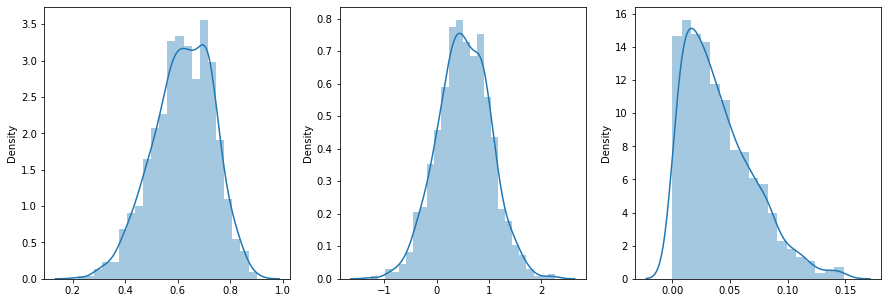

In [12]:
# draw a random z from the prior

# in hddminfo.py `_create_stochastic_knodes_info`
# knodes.update(self._create_family_invlogit('z', value=.5, g_tau=0.5**-2, std_std=0.05))

# def _create_family_invlogit(self, name, value, g_mu=None, g_tau=15**-2,
#                               std_std=0.2, std_value=.1):
#        """Similar to _create_family_normal_normal_hnormal() but adds a invlogit
#        transform knode to the subject and group mean nodes. This is useful
#        when the parameter space is restricted from [0, 1].
#        See _create_family_normal_normal_hnormal() help for more information.
#        """
#
#        if g_mu is None:
#            g_mu = value
#
#        # logit transform values
#        value_trans = np.log(value) - np.log(1-value) 
#        g_mu_trans = np.log(g_mu) - np.log(1-g_mu) # when g_mu = value = 0.5, g_mu_trans = 0
#
#        knodes = OrderedDict()
#
#        if self.is_group_model and name not in self.group_only_nodes:
#            g_trans = Knode(pm.Normal,
#                            '%s_trans'%name,
#                            mu=g_mu_trans,
#                            tau=g_tau,
#                            value=value_trans,
#                            depends=self.depends[name],
#                            plot=False,
#                            hidden=True)
#
#            g = Knode(pm.InvLogit, name, ltheta=g_trans, plot=True, trace=True)
#
#            depends_std = self.depends[name] if self.std_depends else ()
#            std = Knode(pm.HalfNormal, '%s_std' % name, tau=std_std**-2,
#                        value=std_value, depends=depends_std)
#
#            tau = Knode(pm.Deterministic, '%s_tau'%name, doc='%s_tau'
#                        % name, eval=lambda x: x**-2, x=std,
#                        plot=False, trace=False, hidden=True)
#
#            subj_trans = Knode(pm.Normal, '%s_subj_trans'%name,
#                               mu=g_trans, tau=tau, value=value_trans,
#                               depends=('subj_idx',), subj=True,
#                               plot=False, hidden=True)
#
#            subj = Knode(pm.InvLogit, '%s_subj'%name,
#                         ltheta=subj_trans, depends=('subj_idx',),
#                         plot=self.plot_subjs, trace=True, subj=True)
#
#            knodes['%s_trans'%name]      = g_trans
#            knodes['%s'%name]            = g
#            knodes['%s_std'%name]        = std
#            knodes['%s_tau'%name]        = tau
#
#            knodes['%s_subj_trans'%name] = subj_trans
#            knodes['%s_bottom'%name]     = subj
#
#        else:
#            g_trans = Knode(pm.Normal, '%s_trans'%name, mu=g_mu_trans,
#                            tau=g_tau, value=value_trans,
#                            depends=self.depends[name], plot=False, hidden=True)
#
#            g = Knode(pm.InvLogit, '%s'%name, ltheta=g_trans, plot=True,
#                      trace=True )
#
#            knodes['%s_trans'%name] = g_trans
#            knodes['%s_bottom'%name] = g
#
#        return knodes

# in `pymc/distribution.py`
# def rnormal(mu, tau, size=None):
#     """
#     Random normal variates.
#     """
#     return np.random.normal(mu, 1. / np.sqrt(tau), size)

# InvLogit in `pymc/CommonDeterministics.py` <-- invlogit in `pymc/utils.py#L84` <-- `flib.f` (Fortran)
# invlogit in utils.py#L84
# def invlogit(ltheta):
#     return flib.invlogit(ravel(ltheta)).reshape(shape(ltheta))
# numpy.ravel = reshape(-1, order=order), return a contiguous flattened array.

# replace with invlogit in pymc3?
# `pymc3/math.py#L193`
# def invlogit(x, eps=sys.float_info.epsilon):
#     """The inverse of the logit function, 1 / (1 + exp(-x))."""
#    return (1.0 - 2.0 * eps) / (1.0 + tt.exp(-x)) + eps

# can replace `tt` with `np`? yes, almost the same.

# the half_normal ditribution
# def rhalf_normal(tau, size=None):
#     """
#     Random half-normal variates.
#     """

#     return abs(np.random.normal(0, np.sqrt(1 / tau), size))

import sys
def invlogit(ltheta, eps=sys.float_info.epsilon):
    """The inverse of the logit function, 1 / (1 + exp(-x))."""
    ltheta = np.array(ltheta, dtype=np.float128)
    return (1.0 - 2.0 * eps) / (1.0 + np.exp(-ltheta)) + eps

def draw_z_prior(value=.5, g_mu = None, g_tau=0.5**-2, std_std=0.05, size=1):
    
    if g_mu is None:
        g_mu = value
    g_mu_trans = g_mu
    
    # g_mu_trans = np.log(g_mu) - np.log(1-g_mu) #### this deviate from prior!!
    g_trans = np.random.normal(g_mu_trans, 1. / np.sqrt(g_tau), size)
    #print('g_trans is: ', g_trans)
    g = invlogit(ltheta=g_trans)
    
    #print('g is: ', g)
    
    g_tau = std_std**-2
    #print('g_tau is: ', g_tau)
    
    g_std = abs(np.random.normal(0, np.sqrt(1. / g_tau), size=size)) # half normal
    #print('g_std is: ', g_std)
    
    tau = g_std ** -2
    subj_trans = np.random.normal(g_trans, np.sqrt(1./tau), size=size)
    #print('subj_trans is: ', subj_trans)
    #print('tau is: ', tau)
#
    subj_z = invlogit(ltheta=subj_trans)
    
    return subj_z, g_trans, g_std
 
subj_z, g_trans, g_std = draw_z_prior(size=1000)
#z_std = abs(np.random.normal(0, 0.05. ** -2, size = size)) # half normal
#z_mu = np.random.normal(0.5, 0.5 ** -2, size = size)

#v = np.random.normal(v_mu, v_std**-2)
#print(subj_z)


print('mean of mu_z: ', statistics.mean(g_trans))
print('std of mu_z: ', statistics.stdev(g_trans))
print('std of std_z: ', stats.halfnorm.fit(g_std))

f, axes = plt.subplots(1, 3, figsize=(15,5))
sns.distplot(subj_z, ax = axes[0])
sns.distplot(g_trans, ax = axes[1])
sns.distplot(g_std, ax = axes[2])

Check the distribution of each parameter by draw 5000 data from the prior, and check if the parameters (group-level and individual-level) could be recovered.

#### Details of the non-informative prior

##### param $a$



In [13]:
# hddm/models/hddm_info.py#L145 
# knodes.update(self._create_family_trunc_normal('a', lower=1e-3, upper=1e3, value=1))

# /hddm/models/base.py#L371
# def _create_family_trunc_normal(self, name, value=0, lower=None,
#                                    upper=None, std_lower=1e-10,
#                                    std_upper=100, std_value=.1):
#        """Similar to _create_family_normal() but creates a Uniform
#        group distribution and a truncated subject distribution.
#        See _create_family_normal() help for more information.
#        """
#        knodes = OrderedDict()
#
#        if self.is_group_model and name not in self.group_only_nodes:
#            g = Knode(pm.Uniform, '%s' % name, lower=lower,
#                      upper=upper, value=value, depends=self.depends[name])
#
#            depends_std = self.depends[name] if self.std_depends else ()
#            std = Knode(pm.Uniform, '%s_std' % name, lower=std_lower,
#                        upper=std_upper, value=std_value, depends=depends_std)
#            tau = Knode(pm.Deterministic, '%s_tau' % name,
#                        doc='%s_tau' % name, eval=lambda x: x**-2, x=std,
#                        plot=False, trace=False, hidden=True)
#            subj = Knode(pm.TruncatedNormal, '%s_subj' % name, mu=g,
#                         tau=tau, a=lower, b=upper, value=value,
#                         depends=('subj_idx',), subj=True, plot=self.plot_subjs)
#
#            knodes['%s'%name] = g
#            knodes['%s_std'%name] = std
#            knodes['%s_tau'%name] = tau
#            knodes['%s_bottom'%name] = subj
#
#        else:
#            subj = Knode(pm.Uniform, name, lower=lower,
#                         upper=upper, value=value,
#                         depends=self.depends[name])
#            knodes['%s_bottom'%name] = subj
#
#        return knodes
  
# pymc/distributions.py#L2723
# def runiform(lower, upper, size=None):
#     """
#     Random uniform variates.
#      """
#     return np.random.uniform(lower, upper, size)
    
# pymc/distributions.py#L2447
# def rtruncated_normal(mu, tau, a=-np.inf, b=np.inf, size=None):
#     """
#     Random truncated normal variates.
#     """
#
#    sigma = 1. / np.sqrt(tau)
#    na = utils.normcdf((a - mu) / sigma)
#    nb = utils.normcdf((b - mu) / sigma)
#
#    # Use the inverse CDF generation method.
#    U = np.random.mtrand.uniform(size=size)
#    q = U * nb + (1 - U) * na
#    R = utils.invcdf(q)
#
#    # Unnormalize
#     return R * sigma + mu

# /pymc/utils.py#L471
# def invcdf(x):
#     """Inverse of normal cumulative density function."""
#     x_flat = np.ravel(x)
#     x_trans = np.array([flib.ppnd16(y, 1) for y in x_flat])
#     return np.reshape(x_trans, np.shape(x))

# Because utils.invcdf, utils.normcdf here used fortran code `flib`, for me, there are three ways to continue: 
# (1) learn how to import `flib`, which means more on import from local
# (2) sample from normal distribution, and reject value outside the boundary, which is straightforward:
#     https://stackoverflow.com/questions/47933019/how-to-properly-sample-truncated-distributions
# (3) use other way to replace flib invcdf, normcdf, e.g., 
# https://stackoverflow.com/questions/20626994/how-to-calculate-the-inverse-of-the-normal-cumulative-distribution-function-in-p
# 
# I also checked pymc3's code, they use tensor theano

#def invcdf(x):
#    x_flat = np.ravel(x)
#    x_trans = np.array([flib.ppnd16(y, 1) for y in x_flat])
#    return np.reshape(x_trans, np.shape(x))

def rtruncated_normal(mu, tau, a=-np.inf, b=np.inf, size=1):
    from scipy.stats import norm
    sigma = 1. / np.sqrt(tau)
    #na = utils.normcdf((a - mu) / sigma)  # here ther utils.normcdf also used flib
    #nb = utils.normcdf((b - mu) / sigma)
    na = norm.cdf((a - mu) / sigma)
    nb = norm.cdf((b - mu) / sigma)

    # Use the inverse CDF generation method.
    U = np.random.mtrand.uniform(size=size)
    q = U * nb + (1 - U) * na
    
    from scipy.special import ndtri # invcdf mentioned in solution (3) above
    # R = utils.invcdf(q)
    R = ndtri(q)

    # Unnormalize
    return R * sigma + mu

def draw_a_noninfo(lower=1e-3, upper=1e3, size=1):
    g_mu_a = np.random.uniform(low=lower, high=upper, size=size)
    g_std_a = np.random.uniform(low=1e-10, high=100, size=size)
    tau = g_std_a**-2
    #sigma = 1. / np.sqrt(tau)
    
    subj_a = rtruncated_normal(mu=g_mu_a, tau=tau, a=lower, b=upper, size=size)
    
    return subj_a, g_mu_a, g_std_a

mean of subj_:  500.9119318617119
mean of g_mu:  499.01992020218785
std of g_mu:  287.1684216294015
fit of g_std, location and scale:  (0.031753823112173805, 57.57468011713242)


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

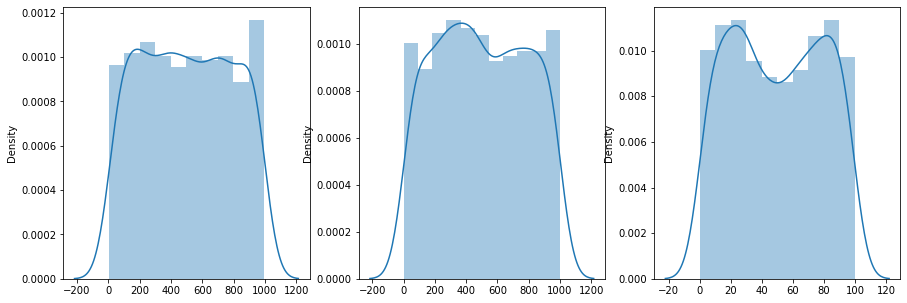

In [14]:
subj_, g_mu, g_std = draw_a_noninfo(size = 1000) # change the draw_z_prior function to other functions

# print(subj_a)
print('mean of subj_: ', statistics.mean(subj_))
print('mean of g_mu: ', statistics.mean(g_mu))
print('std of g_mu: ', statistics.stdev(g_mu))
print('fit of g_std, location and scale: ', stats.halfnorm.fit(g_std))

f, axes = plt.subplots(1, 3, figsize=(15,5))
sns.distplot(subj_, ax = axes[0])
sns.distplot(g_mu, ax = axes[1])
sns.distplot(g_std, ax = axes[2])

draw $t$

In [15]:
# hddm/models/hddm_info.py#L149
# knodes.update(self._create_family_trunc_normal('t', lower=1e-3, upper=1e3, value=.01))

# Almost the same as parameter a, except the `value = 0.01`. for drawing a random value, it's the same. 

def draw_t_noninfo(lower=1e-3, upper=1e3, size=1):
    g_mu_t = np.random.uniform(low=lower, high=upper, size=size)
    g_std_t = np.random.uniform(low=1e-10, high=100, size=size)
    tau = g_std_t**-2
    #sigma = 1. / np.sqrt(tau)
    
    subj_t = rtruncated_normal(mu=g_mu_t, tau=tau, a=lower, b=upper, size=size)
    
    return subj_t, g_mu_t, g_std_t

Draw $v$

mean of mu_v:  1.2875678561735466
std of mu_v:  48.264214387598216
std of std_v:  (0.004620219696316724, 10.20148871217443)


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

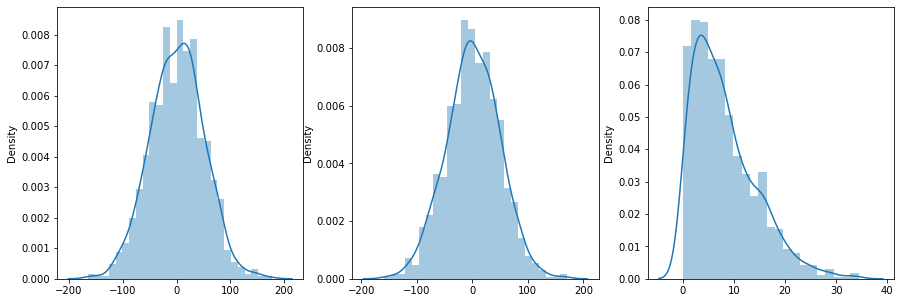

In [16]:
# hddm/models/hddm_info.py#L147
# knodes.update(self._create_family_normal_normal_hnormal('v', value=0, g_tau=50**-2, std_std=10))

# same as the v in informative prior 

# knodes.update(self._create_family_normal_normal_hnormal('v', value=2, g_mu=2, g_tau=3**-2, std_std=2))

def draw_v_noninfo(value=0, g_mu = None, g_tau=50**-2, std_std=10, size=1):
    if g_mu is None:
        g_mu = value
    
    g = np.random.normal(g_mu, 1. / np.sqrt(g_tau), size=size)
    tau_g=std_std**-2
    
    std_g = abs(np.random.normal(0, 1./ np.sqrt(tau_g), size=size)) # half-normal distribution
    
    tau = std_g ** -2
    #print('tau', tau)
    subj_v = np.random.normal(g, 1./ np.sqrt(tau), size=size)
    
    return subj_v, g, std_g
    
subj_v, g, std_g = draw_v_noninfo(size=1000)
#print(subj_v)

print('mean of mu_v: ', statistics.mean(g))
print('std of mu_v: ', statistics.stdev(g))
print('std of std_v: ', stats.halfnorm.fit(std_g))

f, axes = plt.subplots(1, 3, figsize=(15,5))
sns.distplot(subj_v, ax = axes[0])
sns.distplot(g, ax = axes[1])
sns.distplot(std_g, ax = axes[2])

Draw $z$

Q: should we keep the $z$ as a uniform between 0 ~ 1?

mean of mu_z:  0.5265791660299641297
std of mu_z:  0.46393924775458795
std of std_z:  (0.0023535559384676476, 0.4945368874825896)


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

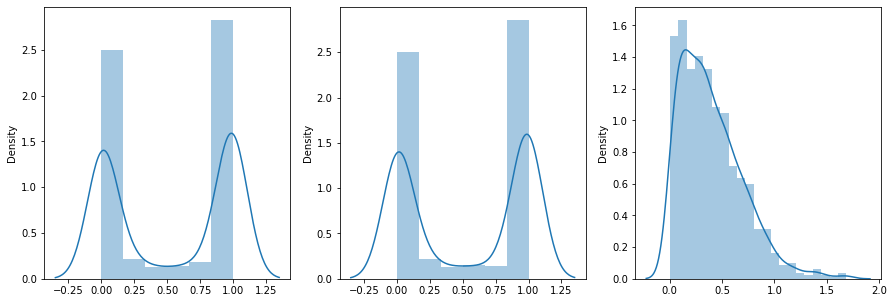

In [17]:
# hddm/models/hddm_info.py#L147
# knodes.update(self._create_family_invlogit('z', value=.5, g_tau=10**-2, std_std=0.5))

# same function as in z in informative prior

# in hddminfo.py `_create_stochastic_knodes_info`
# knodes.update(self._create_family_invlogit('z', value=.5, g_tau=0.5**-2, std_std=0.05))


import sys
def invlogit(ltheta, eps=sys.float_info.epsilon):
    """The inverse of the logit function, 1 / (1 + exp(-x))."""
    ltheta = np.array(ltheta, dtype=np.float128)
    return (1.0 - 2.0 * eps) / (1.0 + np.exp(-ltheta)) + eps

def draw_z_noninfo(value=.5, g_mu = None, g_tau=10**-2, std_std=0.5, size=1):
    
    if g_mu is None:
        g_mu = value
    g_mu_trans = g_mu
    
    # g_mu_trans = np.log(g_mu) - np.log(1-g_mu) #### this deviate from prior!!
    g_trans = np.random.normal(g_mu_trans, 1. / np.sqrt(g_tau), size)
    #print('g_trans is: ', g_trans)
    g = invlogit(ltheta=g_trans)
    
    #print('g is: ', g)
    
    g_tau = std_std**-2
    #print('g_tau is: ', g_tau)
    
    g_std = abs(np.random.normal(0, np.sqrt(1. / g_tau), size=size)) # half normal
    #print('g_std is: ', g_std)
    
    tau = g_std ** -2
    subj_trans = np.random.normal(g_trans, np.sqrt(1./tau), size=size)
   
    subj_z = invlogit(ltheta=subj_trans)
    
    return subj_z, g, g_std
 
subj_z, g_, g_std = draw_z_noninfo(size=1000)

print('mean of mu_z: ', statistics.mean(g_))
print('std of mu_z: ', statistics.stdev(g_))
print('std of std_z: ', stats.halfnorm.fit(g_std))

f, axes = plt.subplots(1, 3, figsize=(15,5))
sns.distplot(subj_z, ax = axes[0])
sns.distplot(g_, ax = axes[1])
sns.distplot(g_std, ax = axes[2])

In [18]:
def gen_data_from_prior(n = 1, type = None):
    '''
    Define a function to simulate the RT and response using params draw from prior
    '''
    import pandas as pd

    cols = ['prior_a', 'prior_v', 'prior_t', 'prior_z',
            'mean_rt', 'acc']
    df = pd.DataFrame(columns=cols)

    for ii in range(n):
        
        # if use wiecki_2013's prior
        if type == 'wiecki_2013':
            
            a = draw_a_prior(size=1)[0][0]
            v = draw_v_prior(size=1)[0][0]
            t = draw_t_prior(size=1)[0][0]
            z = draw_z_prior(size=1)[0][0]
        
        # if use noninformative prior
        elif type == 'noninfo':
            a = draw_a_noninfo(size=1)[0][0]
            v = draw_v_noninfo(size=1)[0][0]
            t = draw_t_noninfo(size=1)[0][0]
            z = draw_z_noninfo(size=1)[0][0]
        else:
            print('Please choose the prior type')
            break

        params = {'a': a,
                  'v': v,
                  't': t,
                  'z': z}

        data, params = hddm.generate.gen_rand_data(params, size=120, subjs=1)
        # Note: not be able to use method = 'drift' of the gen_rt function

        df = df.append({'prior_a': a, 
                        'prior_v': v, 
                        'prior_t': t, 
                        'prior_z': z,
                        'mean_rt': statistics.mean(data['rt']), 
                        'acc': statistics.mean(data['response'])}, 
                       ignore_index=True)

    return df

In [19]:
df = gen_data_from_prior(n = 10000, type = 'noninfo')

/opt/conda/lib/python3.7/site-packages/hddm/generate.py:194: RuntimeWarning: invalid value encountered in true_divide
  size, range_[0], range_[1], dt)


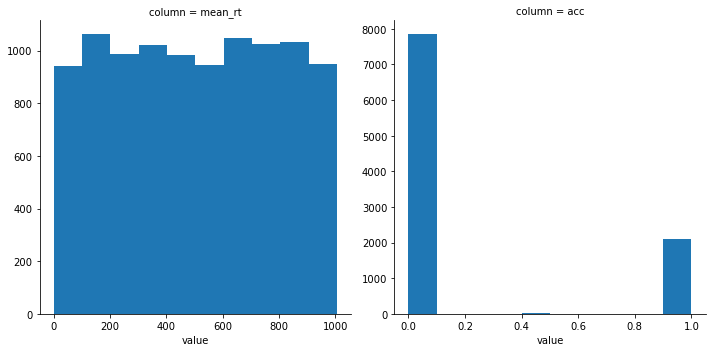

In [20]:
df_s = df[['mean_rt', 'acc']].copy()     # select mean RT and accuracy
df_melted = df_s.melt(var_name='column') # to long format

# plot the long format data
g = sns.FacetGrid(df_melted, col='column', sharex=False, sharey=False, height=5)
g.map(plt.hist, 'value')